# Arima


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from xgboost import XGBRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error

# Libraries
# ======================================================================================
import numpy as np
import pandas as pd
from io import StringIO
import contextlib
import re
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

# pmdarima
from pmdarima import ARIMA
from pmdarima import auto_arima

# statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# skforecast
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax
from sklearn.metrics import mean_absolute_error

import warnings

data_X = pd.read_csv('x_train.csv')
data_X['date']=pd.to_datetime(data_X['date'])

data_y = pd.read_csv('y_train.csv')
X_a_tester = pd.read_csv('x_test.csv')
nb_stations=data_X['station'].nunique()

data_X['y']=data_y['y']


,y
date,
2022-01-01,3441
2022-01-02,5525
2022-01-03,14388
2022-01-04,15690
2022-01-05,15289
...,...
2022-12-27,15451
2022-12-28,14382
2022-12-29,15403


Test stationarity for original series
-------------------------------------
ADF Statistic: -4.0804688042649335, p-value: 0.0010430794785869643
KPSS Statistic: 1.9025815471119105, p-value: 0.01

Test stationarity for differenced series (order=1)
--------------------------------------------------
ADF Statistic: -12.764555838584597, p-value: 8.009429031412074e-24
KPSS Statistic: 0.04897792285511725, p-value: 0.1

Test stationarity for differenced series (order=2)
--------------------------------------------------
ADF Statistic: -18.836666650344107, p-value: 0.0
KPSS Statistic: 0.018834112423262418, p-value: 0.1


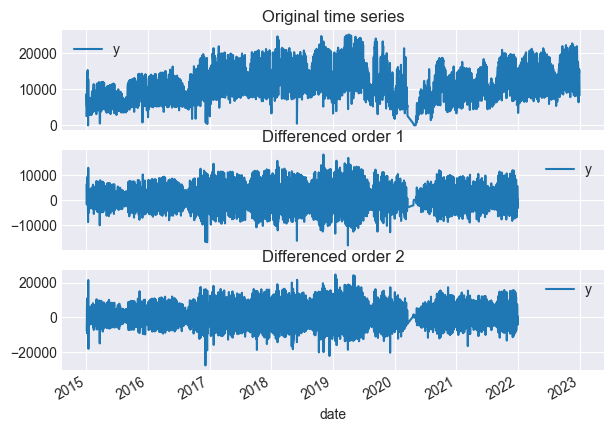

In [2]:
# Test stationarity
# ==============================================================================

data_C5E = data_X[data_X['station'] =='C5E']
data_C5E= data_C5E.drop(['job','station','ferie','vacances'],axis =1)

data_C5E = data_C5E.set_index('date')
data_C5E=data_C5E.sort_index()
data = data_C5E.copy()
data.asfreq('D')
steps = 365

data_train = data[:-365]
data_test  = data[-365:]
warnings.filterwarnings("ignore")
display(data_test)

data_diff_1 = data_train.diff().dropna()
data_diff_2 = data_diff_1.diff().dropna()

print('Test stationarity for original series')
print('-------------------------------------')
adfuller_result = adfuller(data)
kpss_result = kpss(data)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest stationarity for differenced series (order=1)')
print('--------------------------------------------------')
adfuller_result = adfuller(data_diff_1)
kpss_result = kpss(data.diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest stationarity for differenced series (order=2)')
print('--------------------------------------------------')
adfuller_result = adfuller(data_diff_2)
kpss_result = kpss(data.diff().diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

warnings.filterwarnings("default")

# Plot series
# ==============================================================================
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(7, 5), sharex=True)
data.plot(ax=axs[0], title='Original time series')
data_diff_1.plot(ax=axs[1], title='Differenced order 1')
data_diff_2.plot(ax=axs[2], title='Differenced order 2');

Effectivement c'est stationnaire

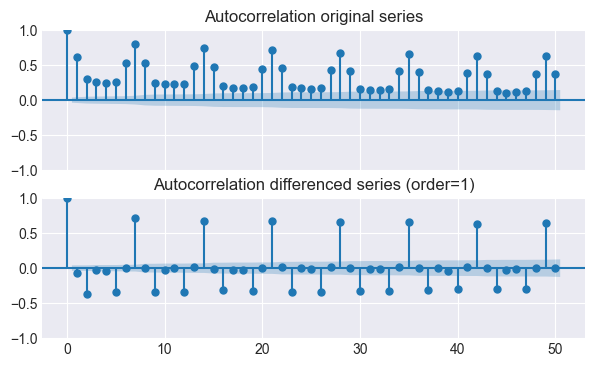

In [3]:
# Autocorrelation plot for original and differenced series
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 4), sharex=True)
plot_acf(data, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelation original series')
plot_acf(data_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autocorrelation differenced series (order=1)');

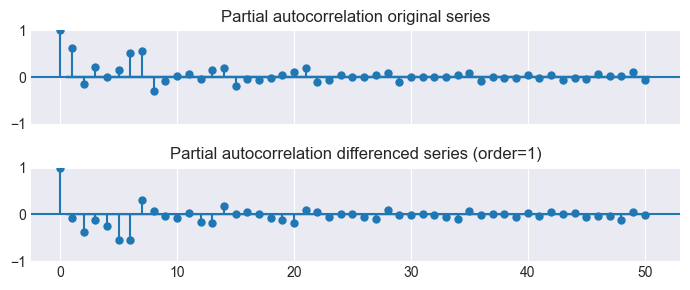

In [4]:
# Partial autocorrelation plot for original and differenced series
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 3), sharex=True)
plot_pacf(data, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Partial autocorrelation original series')
plot_pacf(data_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Partial autocorrelation differenced series (order=1)');
plt.tight_layout();

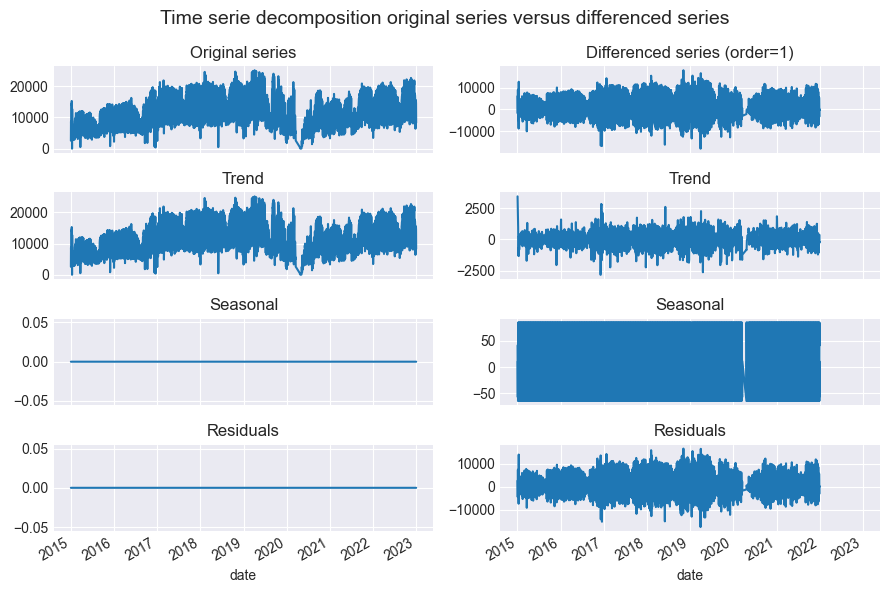

In [5]:
# Time series descoposition of original versus differenced series
# ==============================================================================
res_decompose = seasonal_decompose(data, model='additive', extrapolate_trend='freq',period= 1)
res_descompose_diff_2 = seasonal_decompose(data_diff_1, model='additive', extrapolate_trend='freq',period = 6)

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(9, 6), sharex=True)

res_decompose.observed.plot(ax=axs[0, 0])
axs[0, 0].set_title('Original series')
res_decompose.trend.plot(ax=axs[1, 0])
axs[1, 0].set_title('Trend')
res_decompose.seasonal.plot(ax=axs[2, 0])
axs[2, 0].set_title('Seasonal')
res_decompose.resid.plot(ax=axs[3, 0])
axs[3, 0].set_title('Residuals')
res_descompose_diff_2.observed.plot(ax=axs[0, 1])
axs[0, 1].set_title('Differenced series (order=1)')
res_descompose_diff_2.trend.plot(ax=axs[1, 1])
axs[1, 1].set_title('Trend')
res_descompose_diff_2.seasonal.plot(ax=axs[2, 1])
axs[2, 1].set_title('Seasonal')
res_descompose_diff_2.resid.plot(ax=axs[3, 1])
axs[3, 1].set_title('Residuals')
fig.suptitle('Time serie decomposition original series versus differenced series', fontsize=14)
fig.tight_layout();

In [27]:
import statsmodels.api as sm

# ARIMA model with statsmodels.Sarimax
# ==============================================================================
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
model = sm.tsa.arima.ARIMA(order = (3,0, 0),endog=data_train)
model_res = model.fit()
warnings.filterwarnings("default")

model_res.summary()

c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2516
Model:                 ARIMA(3, 0, 0)   Log Likelihood              -24426.262
Date:                Wed, 27 Mar 2024   AIC                          48862.524
Time:                        11:12:01   BIC                          48891.676
Sample:                             0   HQIC                         48873.104
                               - 2516                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.263e+04    266.999     47.319      0.000    1.21e+04    1.32e+04
ar.L1          0.7446      0.021     35.185      0.000       0.703       0.786
ar.L2         -0.3009      0.025    -11.884      0.000      -0.351      -0.251
ar.L3          0.2323      0.017     13.836      0.000       0.199       0.265
sigma2      1.584e+07      0.007   2.42e+09      0.000    1.58e+07    1.58e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 9.14
Prob(Q):                              0.95   Prob(JB):                         0.01
Heteroskedasticity (H):               1.08   Skew:                             0.15
Prob(H) (two-sided):                  0.24   Kurtosis:                         3.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.38e+24. Standard errors may be unstable.
"""

4794.339959609917


c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


,predictions_statsmodels
2516,10383.082685
2517,11892.999323
2518,12072.313587
2519,11915.963533
2520,12096.290201
...,...
2876,12634.021462
2877,12634.021462
2878,12634.021462
2879,12634.021462


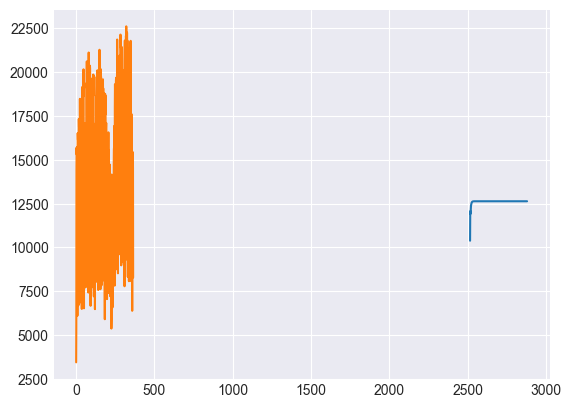

In [28]:
# Prediction
# ==============================================================================
predictions_statsmodels = model_res.forecast(365)
predictions_statsmodels.name = 'predictions_statsmodels'
#print(predictions_statsmodels)

m= mean_absolute_error(predictions_statsmodels,data_test)
print(m)
pred= pd.DataFrame(predictions_statsmodels)
display(pred)
#pred = predictions_statsmodels.reset_index()
d_test = data_test.reset_index()
plt.plot(pred['predictions_statsmodels'])
plt.plot(d_test['y'])